IMPORTING AND LOADING DATA

In [4]:
# utilities
import re
import numpy as np
import pandas as pd
import sqlite3 as sq3
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.tokenize import word_tokenize
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from termcolor import colored

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Sentiment.db'
con = sq3.Connection(path)
query = """
SELECT *
FROM sentiment140_2;
"""
dataset = pd.read_sql(query, con)
dataset.columns = ['target','id','date','flag','user','text']
dataset.head(20)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


EXPLORATORY DATA ANALYSIS

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
dataset['target'].replace((4, 0), (1, -1), inplace=True)
dataset['target'].value_counts()

-1    800000
 1    800000
Name: target, dtype: int64

Two types of sentiments possible:  [-1  1]


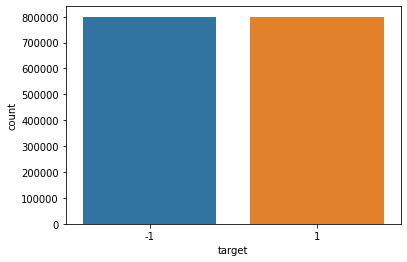

In [8]:
print('Two types of sentiments possible: ', dataset['target'].unique())
sentiment_distribution = sns.countplot(x = "target", data = dataset)

DATA PREPROCESSING

In [9]:
data_text = dataset['text']
data_text.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


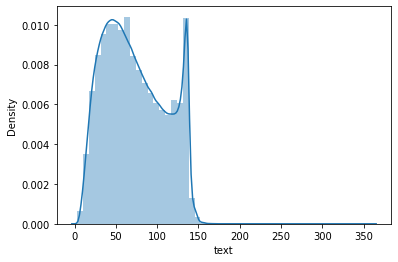

In [10]:
sns.distplot(dataset.text.str.len())
plt.show()

In [11]:
dataset.text.str.len().describe()

count    1.600000e+06
mean     7.326071e+01
std      3.649706e+01
min      3.000000e+00
25%      4.300000e+01
50%      6.800000e+01
75%      1.030000e+02
max      3.590000e+02
Name: text, dtype: float64

In [12]:
STOPWORDS=stopwords.words('english')
STOPWORDS[:5]

['i', 'me', 'my', 'myself', 'we']

In [13]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_text = data_text.apply(lambda text: cleaning_stopwords(text))
data_text.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    upset can't update Facebook texting it... migh...
2    @Kenichan I dived many times ball. Managed sav...
3                     whole body feels itchy like fire
4    @nationwideclass no, behaving all. i'm mad. he...
Name: text, dtype: object

In [14]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_text = data_text.apply(lambda x: cleaning_punctuations(x))
data_text.sample(5)

1377407    kirstiealley ENJOY YOUR CAPRICIOUS CAPTIVATING...
422378     I tummy ache Watching suuuper old episodes Ros...
136370      cut bangs short gonna pull slight side bang look
1407967                                       kevinh545 love
930592               bradhedrick stop watching contact sport
Name: text, dtype: object

In [15]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_text = data_text.apply(lambda x: cleaning_repeating_char(x))
data_text.head()

0    switchfoot httptwitpiccom21zl  Awww thats bumm...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [16]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_text = data_text.apply(lambda x: cleaning_URLs(x))
data_text.head()

0    switchfoot httptwitpiccom21zl  A s bummer You ...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [17]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_text = data_text.apply(lambda x: cleaning_numbers(x))
data_text.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [18]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_text = data_text.apply(lambda x: stemming_on_text(x))
data_text.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [19]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_text = data_text.apply(lambda x: lemmatizer_on_text(x))
data_text.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [20]:
#def tokenize(d):
    #return word_tokenize(d)

#dataset['final_text'] = data_text.apply(tokenize)
#dataset.final_text.head()

In [21]:
#for i in range(len(dataset)):
    #dataset['final_text'][i] = " ".join(dataset['final_text'][i])

#dataset['final_text'][:3]

In [22]:
dataset['final_text'] = data_text

In [23]:
X_train = dataset.final_text
X_train.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: final_text, dtype: object

MACHINE LEARNING

In [24]:
#ratio 80:20 for trainingset and testingset
train_X, test_X, y_train, y_test = train_test_split(X_train, dataset['target'], test_size=0.2, 
                                                    random_state=42, shuffle=True)

print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')

Number of training examples: 1280000
Number of testing examples: 320000


In [25]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)

print(f'Vectoriser fitted.')


Vectoriser fitted.


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(analyzer = 'word', tokenizer = word_tokenize, lowercase = True)
#X_c = c.fit_transform(X)

In [27]:
X_train = c.fit_transform(train_X)
X_test  = c.transform(test_X)
print(f'Data Transformed.')

Data Transformed.


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
model_params = {'random_state':50}
LR =  LogisticRegression(**model_params,solver='liblinear')
KN = KNeighborsClassifier(3)
SVC = SVC(**model_params)
Tree = DecisionTreeClassifier(**model_params)
Forest = RandomForestClassifier(**model_params)
Ada = AdaBoostClassifier(**model_params)
Gau = GaussianNB()
BNB = BernoulliNB(alpha=2)
MNB = MultinomialNB()
CNB = ComplementNB()
MLP = MLPClassifier(**model_params)

In [30]:
a = BNB.fit(X_train, y_train)
b = LR.fit(X_train, y_train)
#c = KN.fit(X_train, y_train)
#d = SVC.fit(X_train, y_train)
#e = Tree.fit(X_train, y_train)
#f = Forest.fit(X_train, y_train)
#g = Ada.fit(X_train, y_train)
j = MNB.fit(X_train, y_train)
h = CNB.fit(X_train, y_train)
#i = MLP.fit(X_train, y_train)

In [38]:
print("Train Accuracy using BernoulliNB: ", BNB.score(X_train, y_train))
pred_BNB = a.predict(X_test)
accuracy = accuracy_score(y_test, pred_BNB)
print("Test Accuracy using BernoulliNB: ", accuracy)

print("Train Accuracy using Logistic Regression: ", LR.score(X_train, y_train))
pred_LR = b.predict(X_test)
accuracy = accuracy_score(pred_LR, y_test)
print("Test Accuracy using Logistic Regression: ", accuracy)

#print(KN.score(X_train, y_train))
#pred = c.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using KNeighbors: ", accuracy)

#print(SVC.score(X_train, y_train))
#pred = d.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Support Vector Classifier: ", accuracy)

#print(Tree.score(X_train, y_train))
#pred = e.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Decision Tree: ", accuracy)

#print(Forest.score(X_train, y_train))
#pred = f.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Random Forest: ", accuracy)

#print(Ada.score(X_train, y_train))
#pred = g.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using AdaBoost: ", accuracy)

print("Train Accuracy using MultimonialNB: ", MNB.score(X_train, y_train))
pred_MNB = j.predict(X_test)
accuracy = accuracy_score(pred_MNB, y_test)
print("Test Accuracy using MultinomialNB: ", accuracy)

print("Train Accuracy using ComplementNB: ", CNB.score(X_train, y_train))
pred_CNB = h.predict(X_test)
accuracy = accuracy_score(pred_CNB, y_test)
print("Test Accuracy using ComplementNB: ", accuracy)

#print(MLP.score(X_train, y_train))
#pred = i.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using MLP Classifier: ", accuracy)

#print(xgb.score(X_train, y_train))
#pred = l.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using XGBClassifier: ", accuracy)

Train Accuracy using BernoulliNB:  0.82439765625
Test Accuracy using BernoulliNB:  0.776165625
Train Accuracy using Logistic Regression:  0.853540625
Test Accuracy using Logistic Regression:  0.784453125
Train Accuracy using MultimonialNB:  0.83874609375
Test Accuracy using MultinomialNB:  0.773340625
Train Accuracy using ComplementNB:  0.838746875
Test Accuracy using ComplementNB:  0.77338125


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.79      0.77      0.78    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



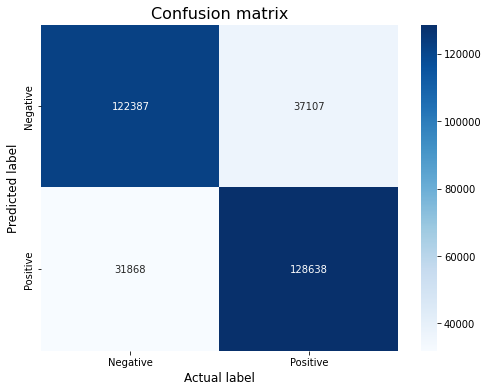

In [32]:
cr = classification_report(y_test, pred_LR)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()



LEXICON VADER

In [33]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in dataset['text'].values.tolist()]
#len(scores) = len(dataset)
dataset['sentiment'] = scores

In [41]:
dataset.loc[dataset['sentiment'] == 0, 'final_sentiment'] = 0
dataset.loc[dataset['sentiment'] > 0, 'final_sentiment'] = 1
dataset.loc[dataset['sentiment'] < 0, 'final_sentiment'] = -1
dataset.head(50)

,target,id,date,flag,user,text,final_text,sentiment,final_sentiment
0,-1,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccomzl A s bummer You sh...,-0.0173,-1.0
1,-1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting it might cr...,-0.7500,-1.0
2,-1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times ball Managed save ...,0.4939,1.0
3,-1,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,-0.2500,-1.0
4,-1,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no behaving all im mad here I ...,-0.6597,-1.0
5,-1,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Kwesidei whole crew,0.0000,0.0
6,-1,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug,Need hug,0.4767,1.0
7,-1,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,LOLTrish hey long time see Yes Rains bit only ...,0.7450,1.0
8,-1,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it,TatianaK nope,0.0000,0.0
9,-1,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?,twittera que muera,0.0000,0.0


In [36]:
from sklearn.metrics import accuracy_score

y_act = dataset['target'].values
y_pred = dataset['final_sentiment'].values

accuracy_score(y_act, y_pred)

0.520999375

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
               precision    recall  f1-score   support

        -1.0       0.81      0.42      0.56    800000
         0.0       0.00      0.00      0.00         0
         1.0       0.66      0.62      0.64    800000

    accuracy                           0.52   1600000
   macro avg       0.49      0.35      0.40   1600000
weighted avg       0.73      0.52      0.60   1600000



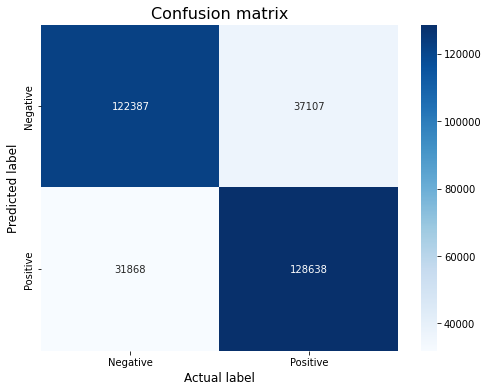

In [40]:
cr = classification_report(y_act, y_pred)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()
